# I made a monthly dataset for a class to work with
 - plotted timeseries
 - big odd drop in t2m in April 1983.  
 - thought there was a delayed response to El Chichon 9/1982 eruption
 - investigating here
 
 ## Results
 - all bad data 4/21 - 4/30  1983
 - really odd data 4/10 - 4/21 near Antarctica


In [1]:
#notebook based on zflemings:https://nbviewer.jupyter.org/github/zflamig/dask-era5/blob/main/notebook/era5_fargate_dask.ipynb
import xarray as xr
import fsspec
import dask
import s3fs
import numpy as np
xr.set_options(display_style="html")  #display dataset nicely 


In [2]:
years,months=[],[]
[years.append(str(y)) for y in np.arange(1983,2020)]
[months.append(str(m).zfill(2)) for m in np.arange(1,13)]
#years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"]
#months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
file_pattern = 's3://era5-pds/{year}/{month}/data/air_temperature_at_2_metres.nc' #air_temperature_at_2_metres.nc'

@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    return fs.open(path)

files_mapper = [s3open(file_pattern.format(year=year,month=month)) for year in years for month in months]
files_mapper

[Delayed('s3open-60becf93-99bf-4933-9808-e39431dfa461'),
 Delayed('s3open-2046e59e-a2f7-4bdf-811d-6d5e6463e324'),
 Delayed('s3open-f31d6e81-7780-4d27-a249-05e51fc97ef4'),
 Delayed('s3open-f177707c-d2e7-4f54-8f12-769b33a502e2'),
 Delayed('s3open-0c047cff-b3d6-4e0b-96f3-ed937ab365e3'),
 Delayed('s3open-bfa6208c-7d81-416c-ad12-0ea14e562a12'),
 Delayed('s3open-49c48f19-f876-4eea-b8ff-82307a69efcf'),
 Delayed('s3open-9f3fa4a8-a8da-4680-8036-72d21979245e'),
 Delayed('s3open-ff993a18-006f-4f88-994b-b105fa17a64c'),
 Delayed('s3open-5d0aa026-7482-4f9b-8f31-4a6960577b36'),
 Delayed('s3open-65983fcc-96d6-4381-af76-4b7bbcccbffa'),
 Delayed('s3open-b002608c-cb1e-43b7-bb4f-7ce164b36140')]

In [3]:
%%time

ds = xr.open_mfdataset(files_mapper, engine='h5netcdf', chunks={'lon':200,'lat':200,'time0':720}, concat_dim='time0', combine='nested', coords='minimal', compat='override', parallel=True)
ds = ds.rename({'time0':'time','air_temperature_at_2_metres':'t2m','lat':'latitude','lon':'longitude'})

ds

CPU times: user 1.9 s, sys: 1.02 s, total: 2.91 s
Wall time: 22.5 s


,Array,Chunk
Bytes,36.38 GB,115.20 MB
Shape,"(8760, 721, 1440)","(720, 200, 200)"
Count,1228 Tasks,608 Chunks
Type,float32,numpy.ndarray


## example of the bad data over antarctica

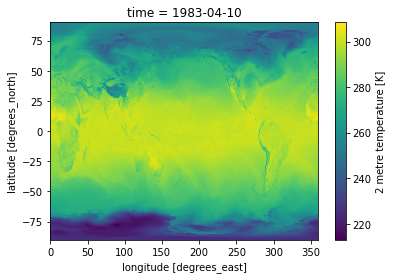

In [4]:
ds.t2m.sel(time='1983-04-10T00').plot()

# look in time at bad point to see when present

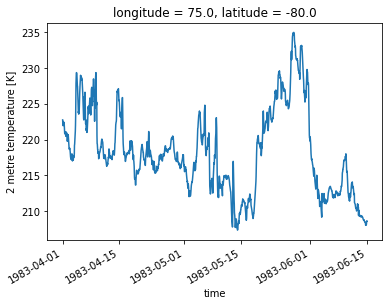

In [5]:
ds.t2m.sel(longitude=75,latitude=-80,method='nearest').sel(time=slice('1983-04-01T00','1983-06-15T00')).plot()

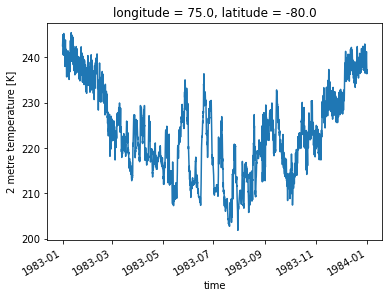

In [6]:
ds.t2m.sel(longitude=75,latitude=-80,method='nearest').sel(time=slice('1982-04-01T00','1985-06-15T00')).plot()

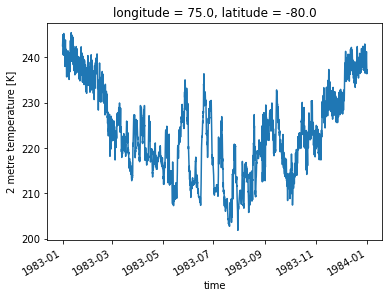

In [7]:
#explore how often these bad data happen in the dataset by plotting timeseries
ds.t2m.sel(longitude=75,latitude=-80,method='nearest').plot()